In [2]:
import cometToolkit as ctk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid

from statsmodels.stats.weightstats import DescrStatsW

from natsort import natsorted
from glob import glob

mpl.rcParams.update({'font.size': 14})

In [3]:
# We want to show all stacked images in one figure for appendix

V = ctk.GetImage(f"../../Python/DataProducts/StackedImages/Day12/vStacked.fits")
R = ctk.GetImage(f"../../Python/DataProducts/StackedImages/Day12/rStacked.fits")
B = ctk.GetImage(f"../../Python/DataProducts/StackedImages/Day12/bStacked.fits")

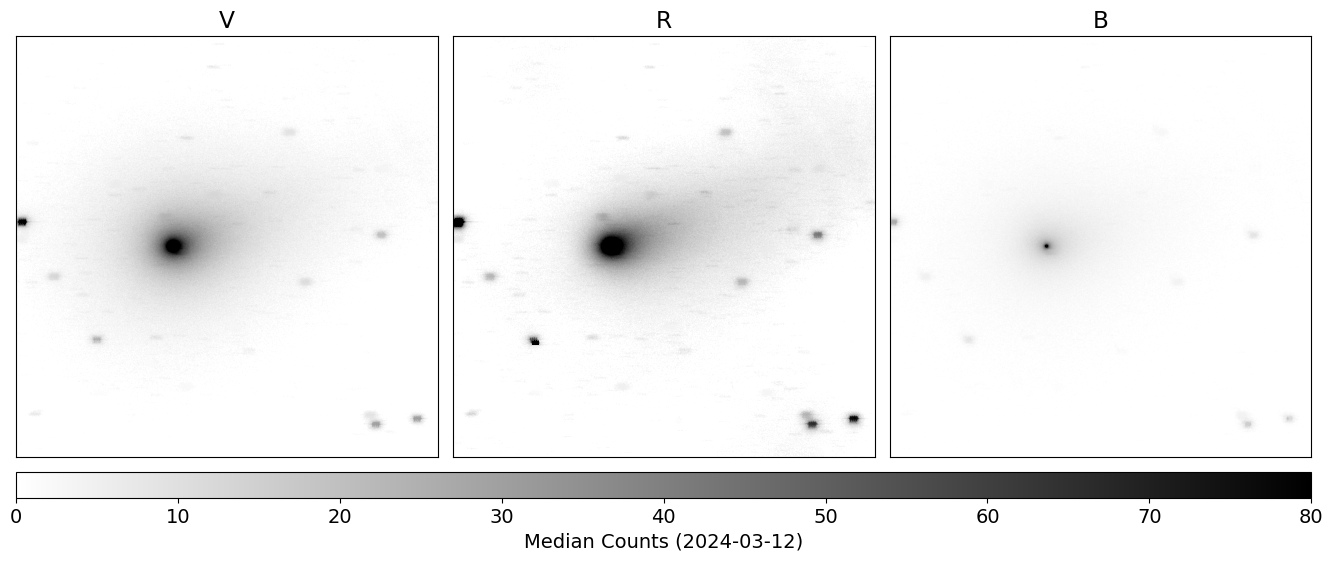

In [4]:
fig = plt.figure(figsize=(18, 6))

titles = ["V", "R", "B"]
images = [V, R, B]
limits = [(0, 80), (0, 80), (0, 80)]

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="bottom",
                 cbar_mode="single",
                 cbar_size="2%",
                 cbar_pad=0,
                 )

for i, ax in enumerate(grid):
    im = ax.imshow(images[i], vmin=limits[i][0], vmax=limits[i][1], cmap="binary")

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(titles[i])

ax.cax.colorbar(im, label="Median Counts (2024-03-12)")

plt.savefig("../../Writing/Thesis/images/stacked_comets.pdf", format="pdf", bbox_inches="tight")

# Context Plot

In [5]:
shortPeriods = np.loadtxt("../../Data/Archive/shortPeriods.txt", delimiter=",")
longPeriods = np.loadtxt("../../Data/Archive/longPeriods.txt", delimiter=",")

In [6]:
# Get our data, weighted average of the R data
activityDataPaths = natsorted(glob("../DataProducts/Activity/Evolution/*"))

activities = []
errors = []

for path in activityDataPaths:
    data = np.loadtxt(path)

    activities.append(data[:,1][1])
    errors.append(data[:,2][1])

activityStats = DescrStatsW(activities, weights=errors)
activityMean = activityStats.mean
activityError = activityStats.std

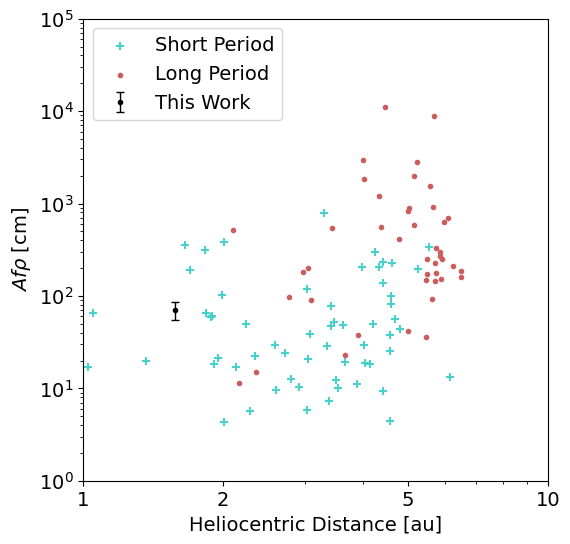

In [8]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(shortPeriods[:,0], shortPeriods[:,1], color="mediumturquoise", marker="+", s=30, label="Short Period")
ax.scatter(longPeriods[:,0], longPeriods[:,1], color="indianred", marker=".", label="Long Period")

ax.errorbar(1.58, activityMean, yerr=activityError, fmt=".", color="black", capsize=3, lw=1, label="This Work")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1, 10)
ax.set_ylim(1, 100000)

ax.set_xticks([1, 2, 5, 10])
ax.set_xticks([3, 4, 6, 7, 8, 9], minor=True)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter("")

ax.set_xlabel("Heliocentric Distance [au]")
ax.set_ylabel(r"$Af\rho$ [cm]")

ax.legend()

plt.savefig("../../Writing/Thesis/images/context_plot.pdf", format="pdf", bbox_inches="tight")